In [1]:
# import packages for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os

In [2]:
from src.fasta_utilities import get_TF_fasta
# obtain the TF fasta file

get_TF_fasta(
    'data/master_tf.csv',
    'data/master_tf.fasta'   
) 

# This file is then processed manually on fldpnn2 server and  
# the output file is saved as 'data/fldpnn2_master.txt'

In [3]:
from src import fldpnn2_scores
fldpnn2_master = fldpnn2_scores.get_scores()
fldpnn2_master

,ID,idr_ranges,AA,Disordered,fldpnn2_score,merged_ranges
0,B7WN96,"Number of disordered regions:8 [3-39,55-60,64-...","[M, E, T, A, N, Y, Y, L, P, S, P, P, Y, S, S, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.233, 0.261, 0.3, 0.352, 0.38, 0.348, 0.399,...","[(3, 39), (55, 74), (163, 166), (196, 239), (2..."
1,P22980,"Number of disordered regions:7 [1-27,31-35,58-...","[M, N, T, E, T, S, T, Q, S, A, P, S, D, T, Y, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.359, 0.368, 0.366, 0.362, 0.365, 0.382, 0.3...","[(1, 35), (58, 143), (227, 324)]"
2,P28515,"Number of disordered regions:16 [16-38,89-93,1...","[M, D, Y, E, G, K, P, V, E, F, T, L, G, T, S, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.206, 0.222, 0.214, 0.241, 0.204, 0.209, 0.1...","[(16, 38), (89, 93), (114, 118), (130, 214), (..."
3,Q10655,"Number of disordered regions:11 [1-6,9-15,18-2...","[M, D, N, N, Y, N, D, N, V, N, G, W, A, E, M, ...","[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0.295, 0.322, 0.351, 0.392, 0.402, 0.332, 0.2...","[(1, 59), (187, 232), (281, 286), (411, 432)]"
4,Q17381,"Number of disordered regions:12 [1-17,21-44,71...","[M, T, S, P, S, S, D, E, D, I, I, D, I, R, V, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.285, 0.294, 0.365, 0.436, 0.429, 0.369, 0.3...","[(1, 44), (71, 84), (97, 118), (160, 214), (31..."
5,Q18612,"Number of disordered regions:5 [1-33,89-103,11...","[M, V, K, S, T, T, A, G, N, N, A, V, S, S, L, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.424, 0.345, 0.328, 0.426, 0.534, 0.577, 0.5...","[(1, 33), (89, 122), (135, 139), (216, 221)]"


In [4]:
# translation of the uniport id to gene name
protein_inf = [
    ('HLH-1', 'P22980'),
    ('ELT-1', 'P28515'),
    ('ELT-2', 'Q10655'),
    ('ELT-3', 'B7WN96'),
    ('PHA-4', 'Q17381'),
    ('HND-1', 'Q18612'),
]
master_gene_names = {
    uniprot_id: gene for (gene, uniprot_id) in protein_inf
}

In [5]:
from src.psphunter_scores import parse_protein_data
# parse data from psphunter of 6 master transcription factors 
psp_master:pd.DataFrame = parse_protein_data()

In [6]:
master = pd.merge(
    fldpnn2_master, 
    psp_master[['ID', 'DRegion']], 
    left_on='ID',
    right_on='ID'
)
master['gene_name'] = master.ID.map(master_gene_names)
master.head(2)

,ID,idr_ranges,AA,Disordered,fldpnn2_score,merged_ranges,DRegion,gene_name
0,B7WN96,"Number of disordered regions:8 [3-39,55-60,64-...","[M, E, T, A, N, Y, Y, L, P, S, P, P, Y, S, S, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.233, 0.261, 0.3, 0.352, 0.38, 0.348, 0.399,...","[(3, 39), (55, 74), (163, 166), (196, 239), (2...","[False, True, True, True, True, True, True, Tr...",ELT-3
1,P22980,"Number of disordered regions:7 [1-27,31-35,58-...","[M, N, T, E, T, S, T, Q, S, A, P, S, D, T, Y, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.359, 0.368, 0.366, 0.362, 0.365, 0.382, 0.3...","[(1, 35), (58, 143), (227, 324)]","[False, False, False, False, False, False, Fal...",HLH-1


In [8]:
idr_data = master[["ID", "gene_name", "merged_ranges", "AA"]]
idr_data.head(2)

,ID,gene_name,merged_ranges,AA
0,B7WN96,ELT-3,"[(3, 39), (55, 74), (163, 166), (196, 239), (2...","[M, E, T, A, N, Y, Y, L, P, S, P, P, Y, S, S, ..."
1,P22980,HLH-1,"[(1, 35), (58, 143), (227, 324)]","[M, N, T, E, T, S, T, Q, S, A, P, S, D, T, Y, ..."


In [9]:
idr_sequences = {}
for i, row in idr_data.iterrows():
    name_id = row['ID']
    gene_name = row['gene_name']
    for i, idr_range in enumerate(row['merged_ranges'], start=1): 
        start, stop = idr_range
        if start > 0: 
            start -= 1
        
        sequence = "".join(row["AA"][start:stop])
        if len(sequence) >= 20:
            idr_sequences[gene_name+f"_{start}_{stop}"] = sequence

df_master_idr = pd.DataFrame(
    idr_sequences.items(), 
    columns=["Name", "Sequence"]
)

df_master_idr.to_csv("data/master_idr.csv")

get_TF_fasta(
    "data/master_idr.csv",
    'data/master_idr.fasta', 
    name='Name'  
) 

In [10]:
albatross_idr_path = 'data/albatross_master_TF_IDR.csv'
albatross_idr = pd.read_csv(albatross_idr_path, index_col=0)
albatross_idr.sequence = albatross_idr.sequence.str.split('''\n''')
albatross_idr.head(3)

,fasta_header,lengths,radius_of_gyration,end_to_end_distance,scaling_exponent,asphericity,prefactor,sequence
0,ELT-3_2_39,37,17.193475,42.746702,0.558046,0.427321,7.199256,"[TANYYLPSPP, YSSTSSSDSR, ESRMNTPIPT, TYSEENV]"
1,ELT-3_54_74,20,11.239770,26.447402,0.556829,0.416606,6.027562,"[TSQKNFWQEG, SPSSSEYLHQ]"
2,ELT-3_195_239,44,20.356483,50.256828,0.564750,0.460837,6.983379,"[PLPLLNSSPT, HPYTTMSNFT, PPPQDPLVAE, PKPMKKRMA..."


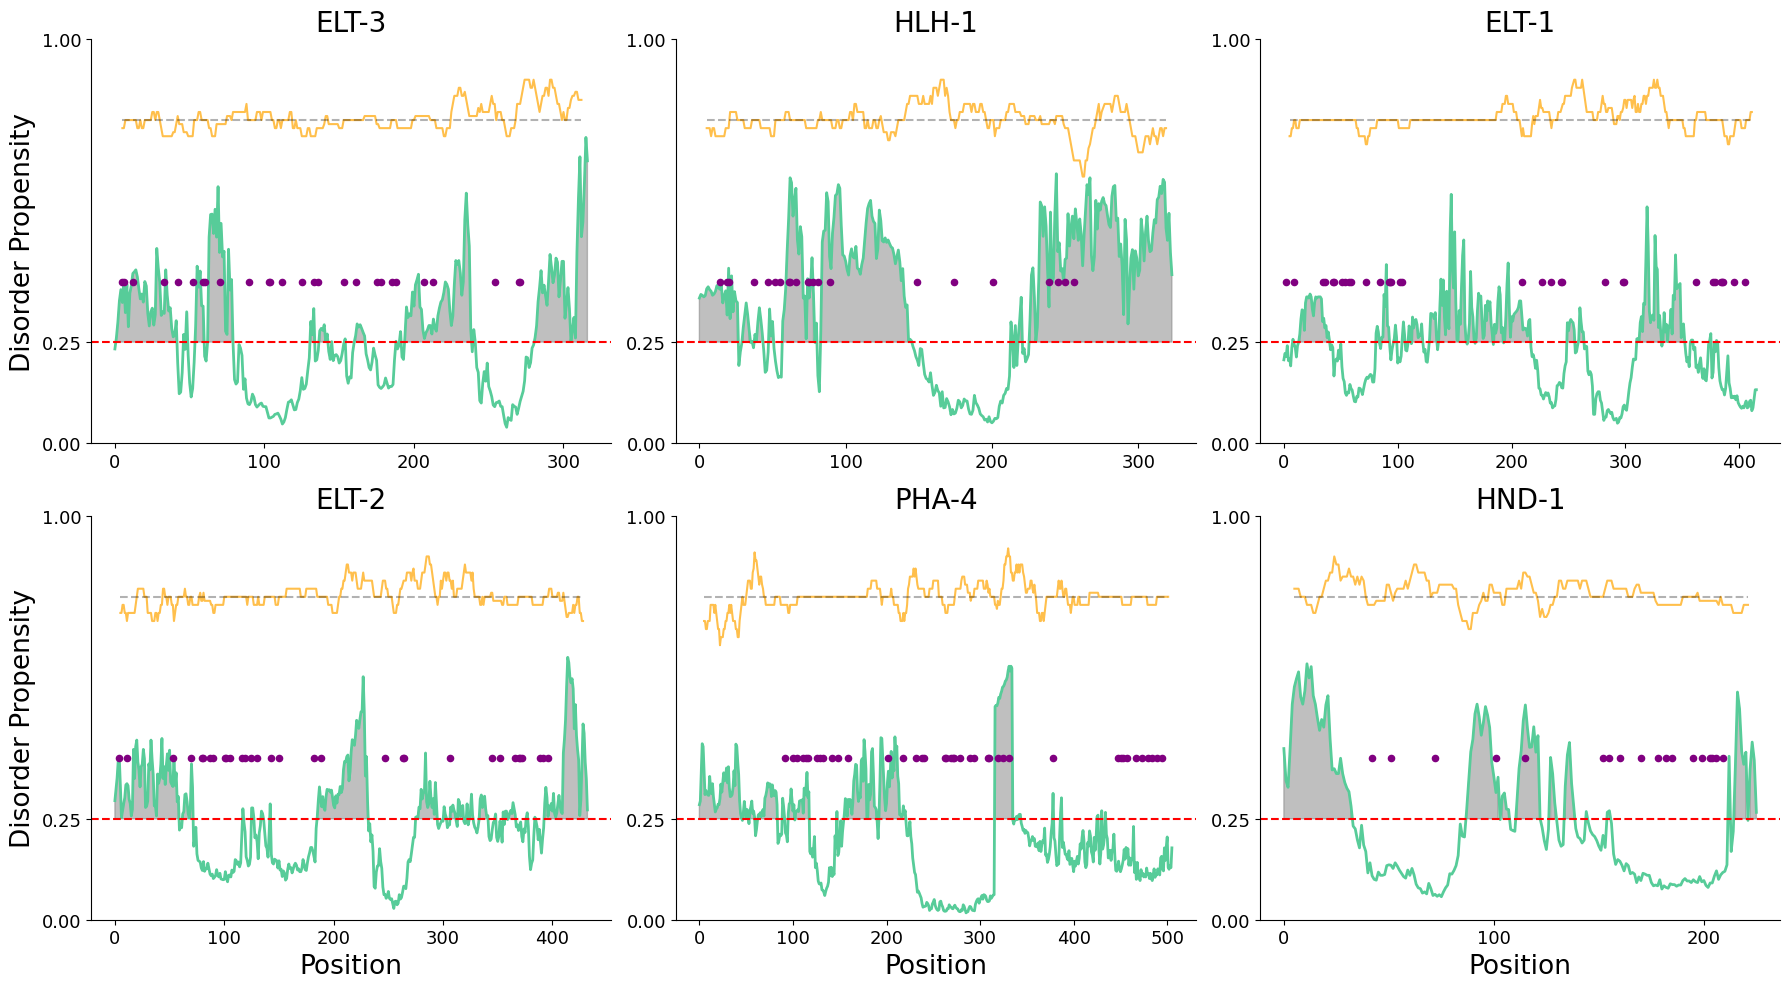

In [12]:
from src.plotting_functions import residue_plot

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=False)

residue_plot(
    axes=axes, 
    data=master, 
    thresh=.25, 
    legends_pos=None, 
)

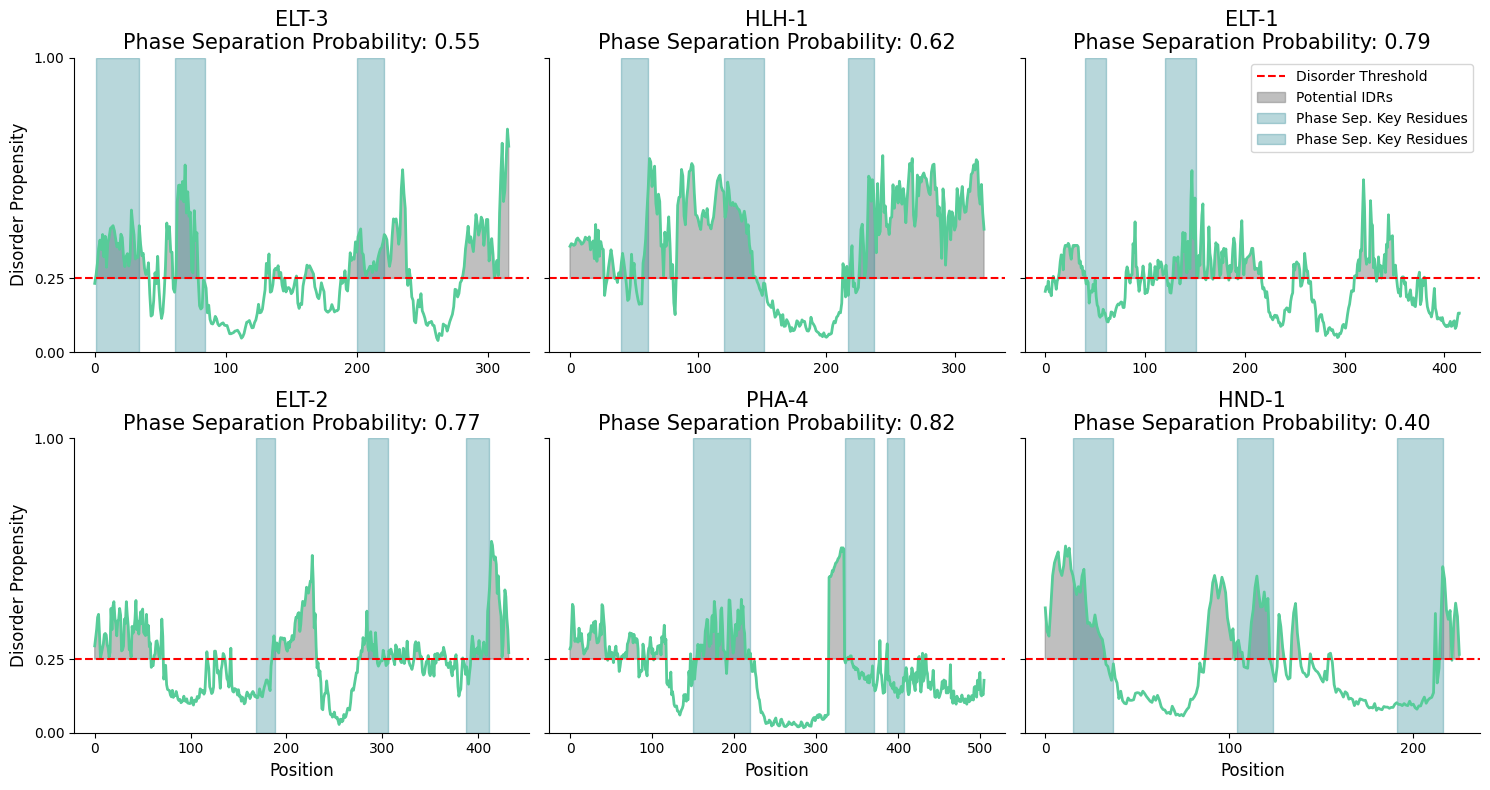

In [14]:
from src.plotting_functions import ps_plot
# Assuming 'master' DataFrame has a column 'bool_list' containing boolean arrays
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
ps_plot(axes,
        master, 
        thresh=0.25, 
        legends_pos=2)